# MNIST

A popular dataframe for first steps and experiments in computer vision. So here are my solutions for MNIST using torch.

In [1]:
from tqdm import tqdm

import pandas as pd

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST

from IPython.display import clear_output

import matplotlib.pyplot as plt

## Downloading data

There is a special module in Torch that allows you to download the MNIST dataset to your computer.

In [2]:
data_train = MNIST(
    "mnist_files",
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
data_valid = MNIST(
    "mnist_files",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

In [3]:
train_loader = DataLoader(data_train, batch_size = 64, shuffle = True)
valid_loader = DataLoader(data_valid, batch_size = 64, shuffle = True)

## Basic network

### Definition and usage

Here is a model that implements a transformation that takes tesnsor describing picture and returns model 10 numbers.

In [4]:
basic_network = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

basic_network(data_train[0][0]).tolist()

[[0.16353461146354675,
  -0.039048705250024796,
  -0.08268115669488907,
  -0.055133551359176636,
  -0.0556013286113739,
  0.07581747323274612,
  0.058930903673172,
  0.03425898775458336,
  -0.0381455197930336,
  -0.10605111718177795]]

We understand the intex of the maximum value as the predicted class. To extract it from the model result, you need to use code like in the cell below.

In [5]:
pred_number, pred_class = torch.max(basic_network(data_train[0][0]), 1)
print("predicted number", pred_number.item())
print("predicted class", pred_class.item())

predicted number 0.16353461146354675
predicted class 0


Or the same code applied to the whole batch.

In [6]:
X, y = next(iter(train_loader))
values, classes = torch.max(basic_network(X), 1)

pd.DataFrame({
    "values" : values.tolist(),
    "classes" : classes.tolist()
}).head()

,values,classes
0,0.127018,7
1,0.098061,5
2,0.115349,6
3,0.055728,5
4,0.054190,5


### Optimization

Below is the function that implements the model training epoch.

In [7]:
def epoch(
    model: nn.Module, 
    data_loader: DataLoader, 
    optimizer: optim.Optimizer, 
    loss_fn
):
    model.train()
    loss_values = []
    
    for x, y in tqdm(data_loader, desc = "train"):
        optimizer.zero_grad()
        output = model(x)
        loss_val = loss_fn(output, y)
        loss_values.append(loss_val.item())
        loss_val.backward()
        optimizer.step()

    return sum(loss_values)/len(loss_values)

### Evaluation

Here is a function that allows you to estimate the loss and accuracy of the model for test data.

In [8]:
optimizer = optim.Adam(basic_network.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()

@torch.inference_mode()
def evaluate(
    model: nn.Module, 
    data_loader: DataLoader, 
    loss_fn
    ):
    loss_values = []
    model.eval()

    total = 0
    correct = 0
 
    for x, y in tqdm(data_loader, desc = "evaluation"):
        output = model(x)
        
        loss_val = loss_fn(output, y)
        loss_values.append(loss_val.item())

        _, classes = torch.max(basic_network(x), 1)
        
        total += len(x)
        correct += (classes == y).sum().item()
    
    return sum(loss_values)/len(loss_values), correct/total

### Fitting

Here is a cycle that runs a few epochs of network load.

In [9]:
train_scores, test_scores, accuracies = [], [], []

for i in range(100):
    train_scores.append(epoch(
        model = basic_network,
        data_loader = train_loader,
        optimizer = optimizer,
        loss_fn = loss_fn
    ))
    test_score, accuracy = evaluate(
        model = basic_network, 
        data_loader = valid_loader,
        loss_fn = loss_fn
    )
    test_scores.append(test_score)
    accuracies.append(accuracy)


    clear_output()
    if accuracy > 0.98:
        break

Visualise the progress of the model in the plots below.

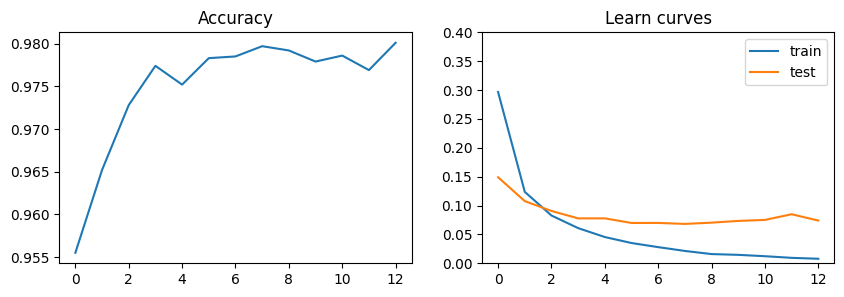

In [10]:
plt.figure(figsize = [10, 3])
plt.subplot(121)
plt.title("Accuracy")
plt.plot(range(len(accuracies)), accuracies)
plt.subplot(122)
plt.title("Learn curves")
plt.plot(range(len(train_scores)), train_scores)
plt.plot(range(len(test_scores)), test_scores)
plt.legend(["train", "test"])
plt.ylim(0,0.4)
plt.show()